# [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/kernels?sortBy=hotness&group=everyone&pageSize=20&language=Python&competitionId=8540)

Can you detect fraudulent click traffic for mobile app ads?

## EDA

In [1]:
# ensure our graphs are displayed inline
%matplotlib inline

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

<Figure size 864x360 with 0 Axes>

We'll first look at the data files we've downloaded for the challenge

In [3]:
print("File sizes")

for f in os.listdir("data/"):
    if "zip" not in f and f.endswith("csv"):
        print(f.ljust(30) + str(round(os.path.getsize("data/" + f) / 1000000, 2)) + " MB")

File sizes
train.csv                     7537.65 MB


While we'd like to work with a small data set, like `train_sample.csv`, its just too small to represent the entire data set `train.csv`. We'll load the entire train set into a DataFrame so we can analyze it

In [4]:
train = pd.read_csv("data/train.csv") # , dtype=dtype, parse_dates=parse_dates)

Now lets peak at the first few values of the data

In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


We'll notice that the features `ip`, `app`, `device`, `os` and `channel` and our class variable `is_attributed` are categorical as they're encoded to anonymize and preserve privacy. Therefore we'll want to ensure we set their type to non-numerical to avoid nonense operations on the data like calculating their `mean`, `median`, ... etc.

In [6]:
categorical_columns = ["ip", "app", "device", "os", "channel", "is_attributed"]

for column in categorical_columns:
    train[column] = train[column].astype('category')

At this point we'll covert the `click_time` and `attributed_time` columns into date time fields, as they represent time series data

In [7]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

Now we'll get a high level look at the training data set

In [8]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,184903890.0,184903890.0,184903890.0,184903890.0,184903890.0,184903890,456846,184903890.0
unique,277396.0,706.0,3475.0,800.0,202.0,259620,182057,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-07 14:00:11,2017-11-08 14:16:29,0.0
freq,1238734.0,33911780.0,174330052.0,44181914.0,15065927.0,1502,14,184447044.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


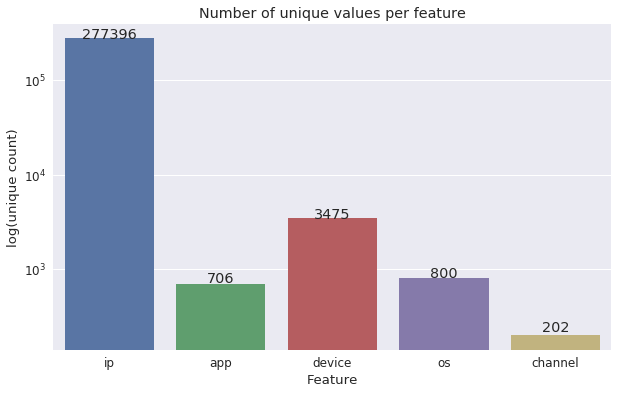

In [9]:
plt.figure(figsize=(10, 6))
cols = ["ip", "app", "device", "os", "channel"]
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel="Feature", ylabel="log(unique count)", title="Number of unique values per feature")

# Places the value just above the column
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            uniq,
            ha="center") 

From our knowledge of the competion, every row in the DataFrame that has a set value of `is_attributed` should also have a value for `attributed_time`. Lets test that belief

In [10]:
# Grabs a subset of the DataFrame and then further grabs only the rows where `is_attributed` is set, then calculating the counts
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,456846,456846.0
unique,182057,1.0
top,2017-11-08 14:16:29,1.0
freq,14,456846.0
first,2017-11-06 16:00:47,NaN
last,2017-11-09 16:00:00,NaN


### Quick Take Aways

- The training set takes place over two days, two hours and eleven seconds
- Out of 184,903,890 rows, only 456,846 of them have an `attributed_time` values of `1.0`
  - This means only 456,846 out of 184,903,890 ad clicks resulted in a download
  - Which is about 0.0025 % of the clicks
- There is atleast one ip adress that triggers an ad click over fifty thousand times
  - Seems strange that one ip address would click that often in a span of just 4 days
  - Does that mean that ip address encoded is not device id, but network id? (explore this below)

Our data is incredilby unbalanced. We're visualizing here the small percents of ad clicks resulting in a download.

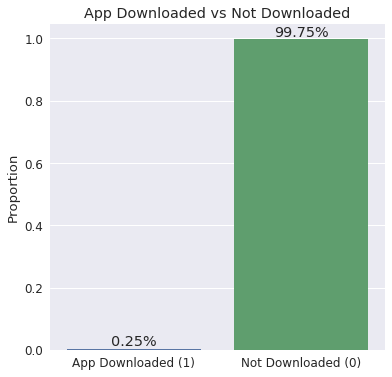

In [11]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Explore ip counts: _Check if multuiple ips have any downloads_

Since we don't know what `ip` is actually encoding, we're going to see if we can make any inferences based on the `value_counts()` of tha data set.

One might think that each `ip` equates to a single user, but we'll see that this is probably not the case.

In [12]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,1238734
1,5314,1171448
2,73516,770451
3,73487,763854
4,53454,498186
5,114276,427453
6,26995,401495
7,95766,378693
8,17149,310996
9,105475,302192


In [13]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [14]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7236133,5348,3,1,41,480,2017-11-06 23:09:14,2017-11-06 23:09:15,1,1238734
54746662,5348,29,2,17,343,2017-11-07 14:19:20,2017-11-07 14:25:10,1,1238734
16559430,5348,107,1,10,171,2017-11-07 02:06:20,2017-11-07 10:09:16,1,1238734
178906362,5348,29,1,19,210,2017-11-09 14:07:48,2017-11-09 14:10:39,1,1238734
39328788,5348,43,1,16,330,2017-11-07 09:25:56,2017-11-07 09:53:30,1,1238734
39331561,5348,29,1,13,343,2017-11-07 09:25:59,2017-11-07 09:26:06,1,1238734
98050686,5348,45,1,9,411,2017-11-08 08:59:23,2017-11-08 11:27:22,1,1238734
48883725,5348,29,1,27,210,2017-11-07 12:28:20,2017-11-07 12:36:01,1,1238734
165853667,5348,20,1,12,259,2017-11-09 10:16:33,2017-11-09 11:18:16,1,1238734
172927660,5348,19,0,50,213,2017-11-09 12:23:26,2017-11-09 12:23:27,1,1238734


In [15]:
train[train['is_attributed']==1].ip.describe()

count     456846
unique    245038
top         5348
freq        2340
Name: ip, dtype: int64

Here we can see up to `2340` downloads for a single IP address. This IP must be for some sort of network with multiple devices.

In [18]:
# convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

### Conversion rates over Counts of 300 most popular IPs

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


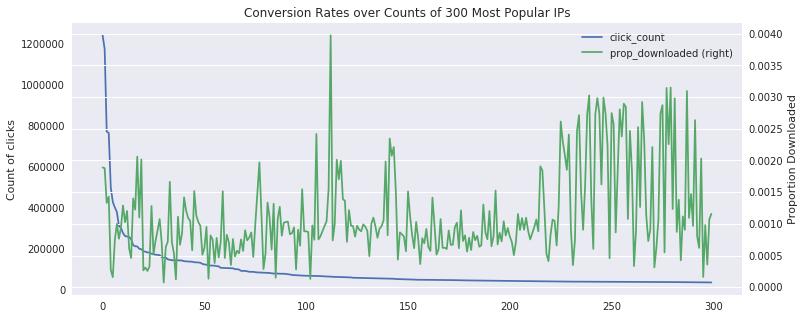

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0     5348      1238734         0.001889
1     5314      1171448         0.001878
2    73516       770451         0.001330
3    73487       763854         0.001428
4    53454       498186         0.000275
5   114276       427453         0.000159
6    26995       401495         0.000747
7    95766       378693         0.001001
8    17149       310996         0.000765
9   105475       302192         0.000943
10  100275       276799         0.001290
11   43793       261970         0.001027
12  105560       260049         0.001204
13   86767       257649         0.000617
14  111025       247187         0.000461
15  137052       217614         0.001402
16  201182       212448         0.001224
17    5178       211556         0.002061
18   49602       200053         0.001100
19    5147       197994         0.002015


In [23]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

There does not seem to be a correlation between the popularity of an `ip` and its `click_count`

## Conversions by App

We'll check out the 100 most popular apps by click count.

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


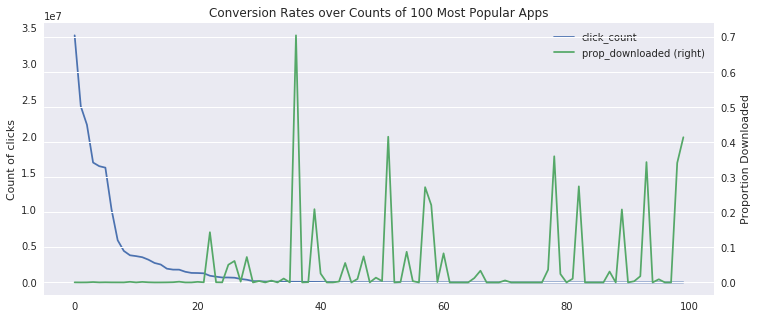

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    3     33911780         0.000303
1   12     24179003         0.000109
2    2     21642136         0.000262
3    9     16458268         0.001144
4   15     15958970         0.000214
5   18     15756587         0.000503
6   14     10027169         0.000250
7    1      5796274         0.000212
8   13      4329409         0.000167
9    8      3731948         0.001842
10  21      3616407         0.000133
11  11      3466971         0.001555
12  26      3126136         0.000467
13  23      2675259         0.000019
14   6      2464136         0.000083
15  64      1893969         0.000266
16   7      1764954         0.000670
17  20      1758934         0.002176
18  25      1467907         0.000047
19  28      1311496         0.000082


In [24]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

We see here a very large difference in the `click_count` per `app`. The largest `click_count` is thirty three million for one app.

We can explain the proportion flucuation as the `click_count` reduces as each click will have a larger impact.

## Conversions by OS

Now we'll look at the top 100 operating systems by `click_count`

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


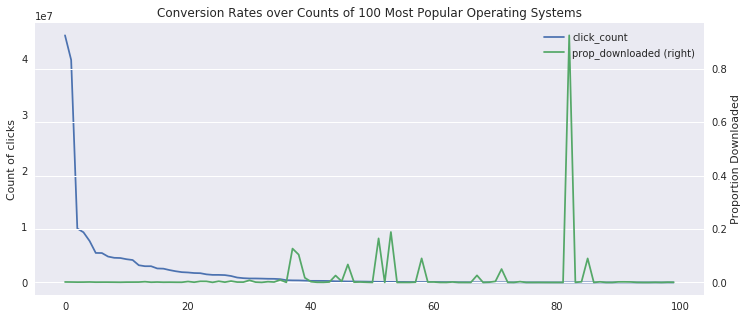

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19     44181914         0.001803
1   13     39782808         0.001549
2   17      9639776         0.001180
3   18      8974159         0.001302
4   22      7414405         0.001769
5    8      5278317         0.001063
6   10      5262422         0.001195
7    6      4632561         0.001184
8   15      4408470         0.000995
9    9      4370878         0.000730
10  25      4156096         0.001219
11  20      4013563         0.001257
12  16      3081268         0.001371
13  37      2905944         0.002832
14   3      2904808         0.000845
15  14      2503681         0.001545
16  41      2467180         0.000808
17   1      2215593         0.001035
18  12      2006410         0.000756
19  23      1844222         0.000681


In [26]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Agin, we can see ratio is very low but as the `click_count` reduces the ratio starts fluxuating more.

## Conversions by Device



## References

* https://www.kaggle.com/anokas/talkingdata-adtracking-eda
  - for usage of inspecting files before choosing which to use for EDA
* https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns
  - for excellent EDA